# PCA Analysis for Charpy Temperature Prediction

## Why PCA for Charpy Temperature?

**Problem**: The dataset contains 50+ features including chemical composition, welding parameters, and process conditions. Many of these features are highly correlated.

**Why PCA is necessary**:

1. **Multicollinearity**: Chemical elements like C, Mn, Si are often correlated due to steel composition requirements. This creates redundant information and unstable model coefficients.

2. **Dimensionality Curse**: With sufficient samples and 50+ features, PCA reduces features while retaining 90-95% of variance, improving model generalization.

3. **Noise Reduction**: Minor variations in measurements contribute little to prediction but add noise. PCA captures systematic variation while filtering noise.

4. **Computational Efficiency**: Training models on 15-20 principal components is faster than 50+ original features, especially for GridSearchCV with cross-validation.

**About Charpy Temperature**: Charpy Temperature (°C) is the testing temperature at which the Charpy impact test is performed. It's a critical parameter for assessing material toughness at different temperatures, especially important for applications in cold environments.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
os.makedirs('pca_model', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [7]:
df = pd.read_csv('../../welddatabase/welddb_pca.csv')
print(f"Prepared dataset shape: {df.shape}")

Prepared dataset shape: (1652, 52)


In [8]:
# Check Charpy Temperature data availability
charpy_temp_available = df['Charpy_Temp_C'].notna().sum()
print(f"Charpy Temperature data available: {charpy_temp_available} samples ({charpy_temp_available/len(df)*100:.1f}%)")

Charpy Temperature data available: 879 samples (53.2%)


In [9]:
target_columns = ['Yield_Strength_MPa', 'UTS_MPa', 'Elongation_%', 
                  'Reduction_Area_%', 'Charpy_Temp_C', 'Charpy_Energy_J',
                  'Hardness_kg_mm2', 'FATT_50%', 'Primary_Ferrite_%',
                  'Ferrite_2nd_Phase_%', 'Acicular_Ferrite_%', 'Martensite_%',
                  'Ferrite_Carbide_%']

df_charpy_temp = df[df['Charpy_Temp_C'].notna()].copy()
y = df_charpy_temp['Charpy_Temp_C'].copy()
X = df_charpy_temp.drop(columns=target_columns)

print(f"Samples with Charpy Temperature: {len(df_charpy_temp)}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nCharpy Temperature statistics:")
print(f"  Mean: {y.mean():.2f}°C")
print(f"  Std: {y.std():.2f}°C")
print(f"  Range: [{y.min():.2f}°C, {y.max():.2f}°C]")

Samples with Charpy Temperature: 879
Features shape: (879, 39)
Target shape: (879,)

Charpy Temperature statistics:
  Mean: 0.00°C
  Std: 1.00°C
  Range: [-2.29°C, 6.41°C]


## Feature Imputation

**Why KNN Imputer?**

KNN Imputer is robust to different missing data mechanisms (MCAR, MAR, MNAR) because:

1. **Non-parametric approach**: Makes no assumptions about data distribution or missing mechanism
2. **Local similarity**: Imputes based on similar samples, preserving relationships between features
3. **Handles correlations**: Leverages multivariate structure naturally present in welding data
4. **Distance-based weighting**: Closer neighbors contribute more, reducing noise from dissimilar samples

In [10]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = imputer.fit_transform(X)

print(f"Missing values before imputation: {X.isnull().sum().sum()}")
print(f"Missing values after imputation: {pd.DataFrame(X_imputed).isnull().sum().sum()}")
print(f"Shape after imputation: {X_imputed.shape}")

Missing values before imputation: 126
Missing values after imputation: 0
Shape after imputation: (879, 39)


In [11]:
joblib.dump(imputer, 'pca_model/imputer.pkl')
print("Imputer saved to: pca_model/imputer.pkl")

Imputer saved to: pca_model/imputer.pkl


## PCA Transformation

Applying PCA to retain 90% of variance, reducing dimensionality while preserving most information.

In [12]:
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_imputed)

print(f"Original features: {X_imputed.shape[1]}")
print(f"PCA components: {X_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {(1 - X_pca.shape[1]/X_imputed.shape[1])*100:.1f}%")

Original features: 39
PCA components: 14
Variance retained: 0.9161
Dimensionality reduction: 64.1%


In [13]:
joblib.dump(pca, 'pca_model/pca_model.pkl')
print("PCA model saved to: pca_model/pca_model.pkl")

PCA model saved to: pca_model/pca_model.pkl


## Save Transformed Data

In [14]:
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns, index=df_charpy_temp.index)
df_pca['Charpy_Temp_C'] = y.values

df_pca.to_csv('data/welddb_pca_charpy_temp.csv', index=False)
print(f"Transformed data saved to: data/welddb_pca_charpy_temp.csv")
print(f"Shape: {df_pca.shape}")
df_pca.head()

Transformed data saved to: data/welddb_pca_charpy_temp.csv
Shape: (879, 15)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Charpy_Temp_C
1,-1.111984,-0.263949,-1.704774,0.393621,0.785069,-0.283643,0.226367,0.411903,0.032662,-1.337822,-1.667102,0.366984,0.316383,0.135545,0.190282
2,-0.416959,-0.867663,-1.822341,0.613313,1.205411,-0.281104,-0.192307,0.296526,0.377337,-0.957682,-1.022218,1.015546,0.631689,0.212360,-0.097746
4,-1.283343,-0.025882,-1.626590,0.429106,0.481750,-0.115155,0.148931,0.648261,-0.375164,-1.112571,-1.015294,0.531599,0.405035,0.250926,-0.385774
5,-0.588318,-0.629596,-1.744157,0.648799,0.902091,-0.112616,-0.269743,0.532884,-0.030489,-0.732431,-0.370411,1.180161,0.720342,0.327741,-0.270563
7,-1.520966,0.236829,-1.476447,0.463252,0.089410,0.091533,-0.088714,0.882214,-0.658019,-0.724643,-0.286923,0.606931,0.452478,0.274635,-0.529788


## Visualization 1: Explained Variance

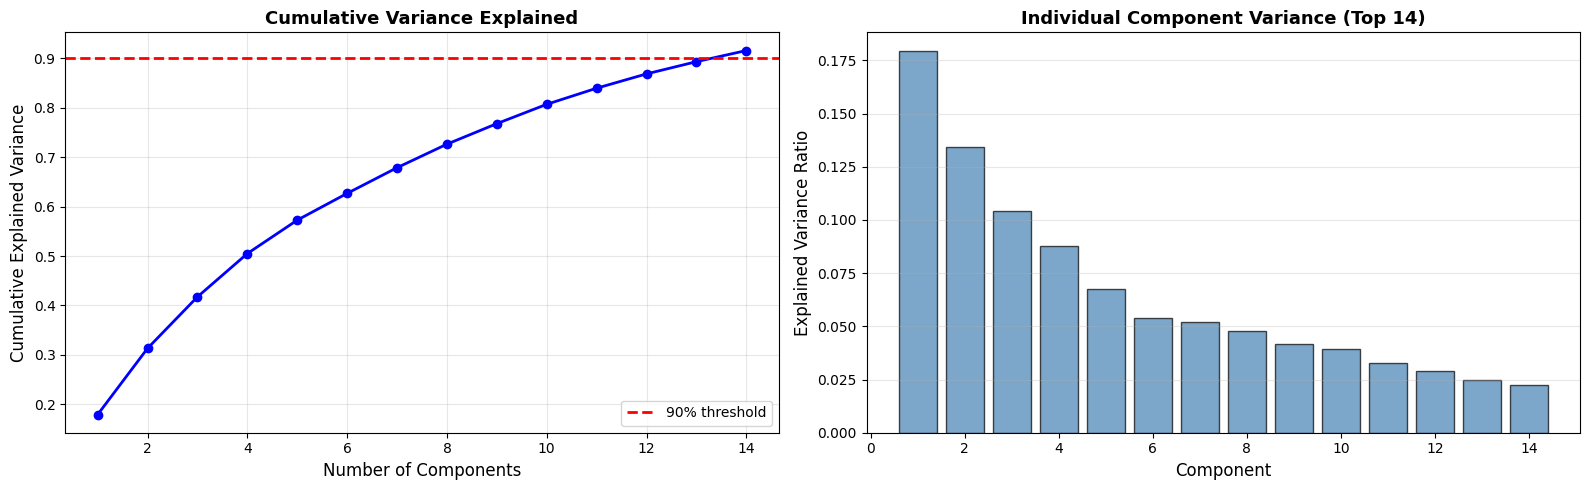

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumsum)+1), cumsum, 'bo-', linewidth=2)
axes[0].axhline(y=0.90, color='r', linestyle='--', linewidth=2, label='90% threshold')
axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Individual variance
n_show = min(15, len(pca.explained_variance_ratio_))
axes[1].bar(range(1, n_show+1), pca.explained_variance_ratio_[:n_show], 
           alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Component', fontsize=12)
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[1].set_title(f'Individual Component Variance (Top {n_show})', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: PCA Scatter Plots

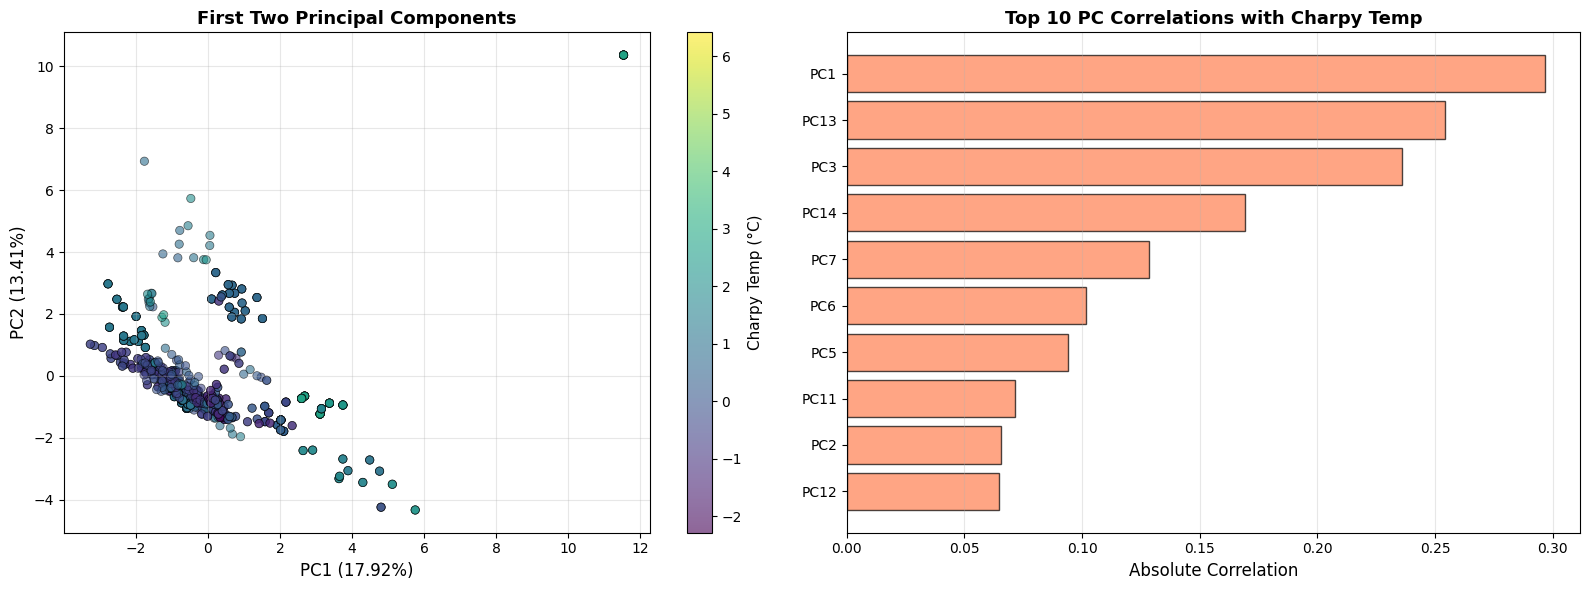


Strongest correlation: 0.297 (PC1)


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D scatter
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', 
                         alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[0].set_title('First Two Principal Components', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Charpy Temp (°C)', fontsize=11)

# Correlation with target
correlations = df_pca.drop('Charpy_Temp_C', axis=1).corrwith(df_pca['Charpy_Temp_C']).abs().sort_values(ascending=False)
n_top = min(10, len(correlations))
axes[1].barh(range(n_top), correlations.head(n_top).values, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(n_top))
axes[1].set_yticklabels(correlations.head(n_top).index)
axes[1].set_xlabel('Absolute Correlation', fontsize=12)
axes[1].set_title('Top 10 PC Correlations with Charpy Temp', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/pca_scatter_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nStrongest correlation: {correlations.iloc[0]:.3f} ({correlations.index[0]})")